In [1]:
import numpy as np
import sys
import torch
import matplotlib.pyplot as plt
sys.path.append("..")

from PIL import Image
from models.mobilenet import MobileNetV3Large
from dataset.transform import TestFocusingTransform, TragetTransform
from dataset.data_module import DataModule

In [2]:
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate


with initialize(version_base=None, config_path="../configs/"):
    config = compose(overrides=["+db=mysql", "+dataset=rgb_dataset_cls", "+model=mobilenet"])

In [3]:
# model = instantiate(config["model"])
# checkpoint_path = "/home/dkrivenkov/program/autofocusing/experiments/mobilenetv3/runs/2022-12-18_19-45-27/weight/epoch=17-step=14472.ckpt"
# checkpoint = torch.load(checkpoint_path)

# update_checkpoint_dict = {}
# for key, value in checkpoint["state_dict"].items():
#     new_name = key[6:]
#     update_checkpoint_dict[new_name] = value

# model.load_state_dict(update_checkpoint_dict)
# model.eval();

In [4]:
datamodule = DataModule(config)

In [5]:
datamodule.prepare_data()

In [6]:
datamodule.setup()

In [16]:
# datamodule.val_data_rgb[2][1]

tensor(7.9500)

In [19]:
from tqdm import trange
a = [datamodule.val_data_rgb[i][1] for i in trange(1000)]



  0%|                                                                                                               | 0/1000 [00:00<?, ?it/s]

  1%|▌                                                                                                      | 6/1000 [00:00<00:19, 50.77it/s]

  1%|█▏                                                                                                    | 12/1000 [00:00<00:20, 49.23it/s]

  2%|█▋                                                                                                    | 17/1000 [00:00<00:20, 48.41it/s]

  2%|██▏                                                                                                   | 22/1000 [00:00<00:20, 47.87it/s]

  3%|██▊                                                                                                   | 27/1000 [00:00<00:24, 40.27it/s]

  3%|███▎                                                                                                  | 32/1000 [00:00<00:26, 36.14it/s

In [25]:
import os

a = os.listdir("/home/dkrivenkov/program/autofocusing/data/data_channel/incoherent_RGBchannels/testRawData_incoherent_sameProtocol/s16_l1")
defocuses = [int(a_[7:-4]) for a_ in a]

In [4]:
image_path = "/home/dkrivenkov/program/autofocusing/data/data_channel/incoherent_RGBchannels/testRawData_incoherent_sameProtocol/s16_l1/defocus-350.jpg"

In [8]:
test_transform = TestFocusingTransform(
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
    add_fourier = False,
    crop_size = (2016, 2240)
)

TypeError: __init__() got an unexpected keyword argument 'crop_size'

In [3]:
image = Image.open(image_path)

NameError: name 'image_path' is not defined

In [4]:
# transform_image = test_transform(np.array(image))[0]

In [12]:
target_transform = TragetTransform(task_type="cls", num_segment=30)
target_transform(10500)

29

In [13]:
# step = 2100
# [(i, i + step + 1) for i in range(-10500, 10500, step)]

In [9]:
# for segment, label in target_transform.segments2label.items():
#     print(segment, label)

In [ ]:
transform_image[1].shape

In [ ]:
def img_to_patch(image, patch_size):
    images = []
    for i in range(0, image.shape[0] - patch_size + 1, patch_size):
        row = []
        for j in range(0, image.shape[1] - patch_size + 1, patch_size):
            row.append(image[i:i+patch_size, j:j+patch_size, :])
        images.append(row)
    return images

def visualise_split(image, prediction=None):
    images = img_to_patch(image, 224)
    fig, ax = plt.subplots(
        nrows=len(images),
        ncols=len(images[0]),
        figsize=(15, 15)
    )
    for i in range(len(images)):
        for j in range(len(images[0])):
            ax[i, j].imshow(images[i][j])
            ax[i, j].axis('off')
            
            if prediction is not None:
                ax[i, j].set_title(prediction[i, j])

In [4]:
visualise_split(np.array(image))

NameError: name 'visualise_split' is not defined

In [5]:
predictions = []
for i in range(transform_image.shape[0]):
    with torch.no_grad():
        pred_distance = model(transform_image[i].unsqueeze(0))
        predictions.append(pred_distance.item())

NameError: name 'transform_image' is not defined

In [ ]:
errors = np.abs(np.array(predictions) - (-350 / 1000)).reshape(9, 10)

In [ ]:
errors = np.round(errors, 1)

In [ ]:
errors.sort()

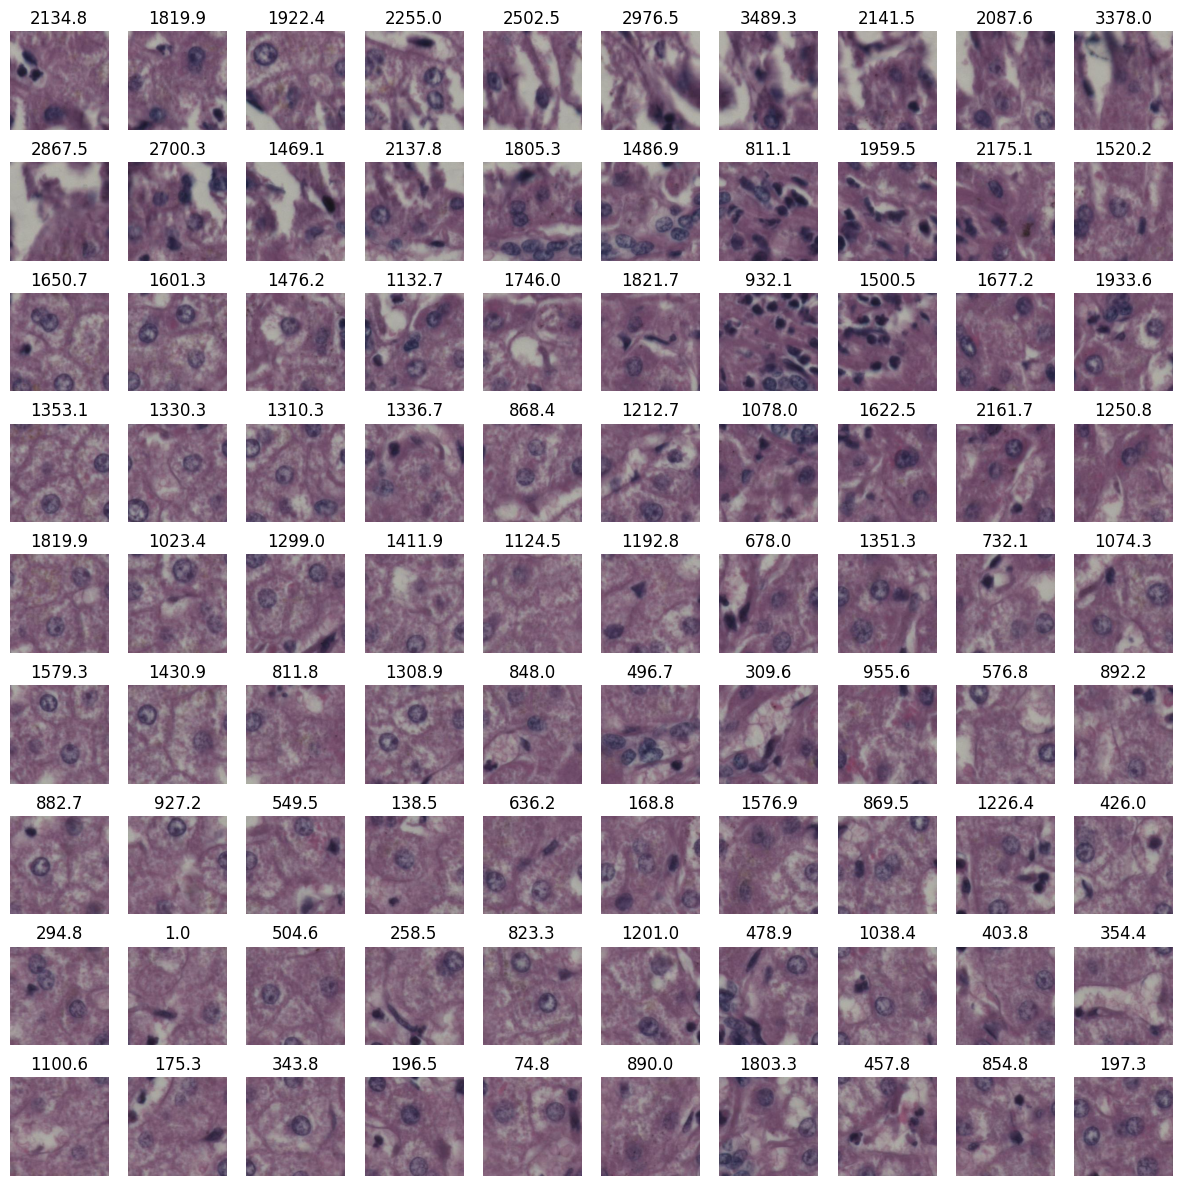

In [14]:
visualise_split(np.array(image), errors)

In [18]:
import scipy.signal as signal
import scipy.special as special
import scipy.optimize as optimize
import collections

In [19]:
def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def gaussian_kernel2d(n, sigma):
    Y, X = np.indices((n, n)) - int(n/2)
    gaussian_kernel = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2)) 
    return normalize_kernel(gaussian_kernel)

def local_mean(image, kernel):
    return signal.convolve2d(image, kernel, 'same')
                             
def local_deviation(image, local_mean, kernel):
    "Vectorized approximation of local deviation"
    sigma = image ** 2
    sigma = signal.convolve2d(sigma, kernel, 'same')
    return np.sqrt(np.abs(local_mean ** 2 - sigma))
                             
def calculate_mscn_coefficients(image, kernel_size=6, sigma=7/6):
    C = 1/255
    kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
    local_mean = signal.convolve2d(image, kernel, 'same')
    local_var = local_deviation(image, local_mean, kernel)
    return (image - local_mean) / (local_var + C)


def generalized_gaussian_dist(x, alpha, sigma):
    beta = sigma * np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    
    coefficient = alpha / (2 * beta() * special.gamma(1 / alpha))
    return coefficient * np.exp(-(np.abs(x) / beta) ** alpha)

def calculate_pair_product_coefficients(mscn_coefficients):
    return collections.OrderedDict({
        'mscn': mscn_coefficients,
        'horizontal': mscn_coefficients[:, :-1] * mscn_coefficients[:, 1:],
        'vertical': mscn_coefficients[:-1, :] * mscn_coefficients[1:, :],
        'main_diagonal': mscn_coefficients[:-1, :-1] * mscn_coefficients[1:, 1:],
        'secondary_diagonal': mscn_coefficients[1:, :-1] * mscn_coefficients[:-1, 1:]
    })

def asymmetric_generalized_gaussian(x, nu, sigma_l, sigma_r):
    def beta(sigma):
        return sigma * np.sqrt(special.gamma(1 / nu) / special.gamma(3 / nu))
    
    coefficient = nu / ((beta(sigma_l) + beta(sigma_r)) * special.gamma(1 / nu))
    f = lambda x, sigma: coefficient * np.exp(-(x / beta(sigma)) ** nu)
        
    return np.where(x < 0, f(-x, sigma_l), f(x, sigma_r))

In [20]:
def asymmetric_generalized_gaussian_fit(x):
    def estimate_phi(alpha):
        numerator = special.gamma(2 / alpha) ** 2
        denominator = special.gamma(1 / alpha) * special.gamma(3 / alpha)
        return numerator / denominator

    def estimate_r_hat(x):
        size = np.prod(x.shape)
        return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)

    def estimate_R_hat(r_hat, gamma):
        numerator = (gamma ** 3 + 1) * (gamma + 1)
        denominator = (gamma ** 2 + 1) ** 2
        return r_hat * numerator / denominator

    def mean_squares_sum(x, filter = lambda z: z == z):
        filtered_values = x[filter(x)]
        squares_sum = np.sum(filtered_values ** 2)
        return squares_sum / ((filtered_values.shape))

    def estimate_gamma(x):
        left_squares = mean_squares_sum(x, lambda z: z < 0)
        right_squares = mean_squares_sum(x, lambda z: z >= 0)

        return np.sqrt(left_squares) / np.sqrt(right_squares)

    def estimate_alpha(x):
        r_hat = estimate_r_hat(x)
        gamma = estimate_gamma(x)
        R_hat = estimate_R_hat(r_hat, gamma)

        solution = optimize.root(lambda z: estimate_phi(z) - R_hat, [0.2]).x

        return solution[0]

    def estimate_sigma(x, alpha, filter = lambda z: z < 0):
        return np.sqrt(mean_squares_sum(x, filter))
    
    def estimate_mean(alpha, sigma_l, sigma_r):
        return (sigma_r - sigma_l) * constant * (special.gamma(2 / alpha) / special.gamma(1 / alpha))
    
    alpha = estimate_alpha(x)
    sigma_l = estimate_sigma(x, alpha, lambda z: z < 0)
    sigma_r = estimate_sigma(x, alpha, lambda z: z >= 0)
    
    constant = np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    mean = estimate_mean(alpha, sigma_l, sigma_r)
    
    return alpha, mean, sigma_l, sigma_r

In [21]:
def calculate_brisque_features(image, kernel_size=7, sigma=7/6):
    def calculate_features(coefficients_name, coefficients):
        alpha, mean, sigma_l, sigma_r = asymmetric_generalized_gaussian_fit(coefficients)

        if coefficients_name == 'mscn':
            var = (sigma_l ** 2 + sigma_r ** 2) / 2
            return [alpha, var]
        
        return [alpha, mean, sigma_l ** 2, sigma_r ** 2]
    
    mscn_coefficients = calculate_mscn_coefficients(image, kernel_size, sigma)
    coefficients = calculate_pair_product_coefficients(mscn_coefficients)
    
    features = [calculate_features(name, coeff) for name, coeff in coefficients.items()]
    flatten_features = list(chain.from_iterable(features))
    return flatten_features

In [27]:
calculate_mscn_coefficients(gray, kernel_size=7, sigma=7/6).shape

(2048, 2448)

In [28]:
gray.shape

(2048, 2448)

In [22]:
import cv2
from itertools import chain

image = cv2.imread(image_path)[:,:,::-1]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
downscaled_image = cv2.resize(gray, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)

downscale_brisque_features = calculate_brisque_features(downscaled_image, kernel_size=7, sigma=7/6)
brisque_features = calculate_brisque_features(gray, kernel_size=7, sigma=7/6)

brisque_features = np.concatenate((brisque_features, downscale_brisque_features))
brisque_features = np.array([float(feature) for feature in brisque_features])

In [23]:
import pickle
def scale_features(features):
    with open('normalize.pickle', 'rb') as handle:
        scale_params = pickle.load(handle)
    
    min_ = np.array(scale_params['min_'])
    max_ = np.array(scale_params['max_'])
    
    return -1 + (2.0 / (max_ - min_) * (features - min_))

In [24]:
scaled_brisque_features = scale_features(brisque_features)

In [25]:
scaled_brisque_features

array([-0.97501123, -1.04798509, -1.1833053 , -0.23029651, -1.00046881,
       -1.00227756, -1.1835983 , -0.1439648 , -1.00046274, -1.00226888,
       -1.154489  ,  0.12229599, -1.00052078, -1.00142099, -1.15766938,
        0.14005617, -1.00052808, -1.00155231, -0.8205943 , -1.03684306,
       -1.24045951,  0.07707868, -1.00027218, -1.00317335, -1.25384537,
        0.13467289, -1.00029546, -1.00354986, -1.00670377,  0.25858402,
       -1.00035204, -1.00124181, -1.00896545,  0.25378512, -1.0003687 ,
       -1.00122043])